# Class Conditional DDIM

## Setup

In [1]:
import math
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import cv2
import pandas as pd
import numpy as np
import datetime
from PIL import Image
    
from tensorflow import keras
from keras import layers

### tensorflow numba 확인

In [2]:
# !echo 0 | sudo tee -a /sys/bus/pci/devices/0000\:00\:04.0/numa_node

## GPU 확인

In [3]:
import tensorflow as tf

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 18308954647741625828,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14474280960
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 18018872242538550148
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

## 하이퍼 파라미터

In [4]:
# 데이터
# 사용할 데이터셋 이름 : tf.dataset
# dataset_name = "oxford_flowers102"
dataset_name = "cifar10"
# 반복할 횟수(1이상으로 잡아야 돌아갑니다.)
# dataset_repetitions = 3
dataset_repetitions = 1
# Epoch
num_epochs = 50
# num_epochs = 1

# resize시 정할 이미지
# image_size = 256
image_size = 32

# 데이터셋 컬러여부
# image_colored = 0
image_colored = 1


# KID = Kernel Inception Distance, see related section
kid_image_size = 75
# kid_image_size = 128
#kid_diffusion_steps = 5
kid_diffusion_steps = 20
# plot_diffusion_steps = 20
plot_diffusion_steps = 1000
# one_plot_diffusion_steps = 20
one_plot_diffusion_steps = 1000

# 

# sampling
min_signal_rate = 0.02
max_signal_rate = 0.95

# architecture
embedding_dims = 32
embedding_max_frequency = 1000.0
widths = [32, 64, 96, 128] # 길게 늘일지 그대로 두배 할지
block_depth = 4 # 4

# optimization
batch_size = 64
# batch_size = 16
ema = 0.999
#learning_rate = 1e-3
learning_rate = 2e-5

#weight_decay = 1e-4
weight_decay = 1e-6


# class
num_class = 10
class_embedding_dims = 32

In [5]:
tfds.load(dataset_name)

{'train': <PrefetchDataset shapes: {id: (), image: (32, 32, 3), label: ()}, types: {id: tf.string, image: tf.uint8, label: tf.int64}>,
 'test': <PrefetchDataset shapes: {id: (), image: (32, 32, 3), label: ()}, types: {id: tf.string, image: tf.uint8, label: tf.int64}>}

## 데이터 파이프라인

### 변경 전

In [6]:
# # 이미지의 너비와 높이 중 짧은 길이에 맞춰서 center crop하는 함수
# def preprocess_image_before(data):
#     # center crop image
#     height = tf.shape(data["image"])[0]
#     width = tf.shape(data["image"])[1]
#     crop_size = tf.minimum(height, width)
#     image = tf.image.crop_to_bounding_box(
#         data["image"],
#         (height - crop_size) // 2,
#         (width - crop_size) // 2,
#         crop_size,
#         crop_size,
#     )

    
#     # Center crop한 이미지를 Hyper parameter에서 정해준 image_size에 맞게 resize 해줍니다.
#     # resize시 이미지 훼손을 최대한 방지하기 위해 antialias를 True로 해줍니다.
#     image = tf.image.resize(image, size=[image_size, image_size], antialias=True)
#     # 이미지 Array의 값을 float 0~1로 만들어주고 혹시 모를 특이값을 방지하기 위해 clip을 해줍니다.
#     return tf.clip_by_value(image / 255.0, 0.0, 1.0)


# # 데이터셋을 준비하는 함수
# def prepare_dataset_before(split):
#     # KID 측정을 위해서는 shuffle이 되어야 합니다. 데이터 순서가 영향을 주기 때문입니다.
#     return (
#         # tfds.load를 통해 Hyper parameter에서 정해준 이름의 Dataset을 불러옵니다.
#         # 추가로 split 문자열을 통해 train, (validation), test에서 나눠서 가져옵니다.
#         # shuffle_files를 통해 파일을 섞어줍니다.
#         tfds.load(dataset_name, split=split, shuffle_files=True, )
#         # map 함수는 해당 함수(ppreprocess_image)를 내부의 값에 모두 적용하는 함수 입니다.
#         # num_parallel_calls : 병렬적으로 수행할 요소들의 숫자를 정합니다.
#         # tf.data.AUTOTUNE을 적용하면 현재 CPU에 맞게 적용됩니다.
#         .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
#         # 해당 데이터셋의 내부 원소들을 캐시합니다.
#         # (캐시 : CPU와 주 메모리 사이에 삽입되는 작고 빠른 메모리 구성요소)
#         # 캐시한다 : 여기에 데이터를 올려서 속도 개선
#         .cache()
#         # 내부 모든 값을 반복합니다.(여러번 concate 한다고 생각하면 됩니다.)
#         .repeat(dataset_repetitions)
#         # shuffle
#         # buffer : 데이터를 전송하기 전에 일시적으로 데이터를 보관하는 메모리의 영역(이동하고자하는 모든 데이터를 담게 된다.)
#         .shuffle(10 * batch_size)
#         # batch_size에 맞춰 batch를 나눕니다. drop_remainder = True가 된다면 batch 보다 적게 남으면 버립니다.
#         .batch(batch_size, drop_remainder=True)
#         # 대부분의 Dataset이 prefetch를 통해 끝이 난다.
#         # prefetch는 나중의 요소들이 현재 요소들이 계산되느 동안 준비되게 한다.
#         .prefetch(buffer_size=tf.data.AUTOTUNE)
#     )

# 데이터셋 불러오기
# train 데이터셋은 train, validation, test의 0~80 부분을 가져옵니다.
# train_dataset = prepare_dataset("train[:80%]+validation[:80%]+test[:80%]")
# test 데이터셋은 train, validation, test의 80~100 부분을 가져옵니다.
# val_dataset = prepare_dataset("train[80%:]+validation[80%:]+test[80%:]")

# print(train_dataset)
# print(val_dataset)

### 변경

In [7]:
# 이미지의 너비와 높이 중 짧은 길이에 맞춰서 center crop하는 함수
def preprocess_image(data):
    # center crop image
    height = tf.shape(data["image"])[0]
    width = tf.shape(data["image"])[1]
    crop_size = tf.minimum(height, width)
    image = tf.image.crop_to_bounding_box(
        data["image"],
        (height - crop_size) // 2,
        (width - crop_size) // 2,
        crop_size,
        crop_size,
    )
    c_vect = tf.one_hot(indices = data["label"], depth = num_class, dtype = tf.int64)
    # Center crop한 이미지를 Hyper parameter에서 정해준 image_size에 맞게 resize 해줍니다.
    # resize시 이미지 훼손을 최대한 방지하기 위해 antialias를 True로 해줍ㄴ디ㅏ.
    image = tf.image.resize(image, size=[image_size, image_size], antialias=True)
    
    # 흑백을 컬러로 변경
    if image_colored == 0:
        image = tf.tile(image, (1, 1, 3))
    
    # 이미지 Array의 값을 float 0~1로 만들어주고 혹시 모를 특이값을 방지하기 위해 clip을 해줍니다.
    return {'image': tf.clip_by_value(image / 255.0, 0.0, 1.0), 'label' : c_vect}


# 데이터셋을 준비하는 함수
def prepare_dataset(split):
    # KID 측정을 위해서는 shuffle이 되어야 합니다. 데이터 순서가 영향을 주기 때문입니다.
    # tfds.load를 통해 Hyper parameter에서 정해준 이름의 Dataset을 불러옵니다.
    # 추가로 split 문자열을 통해 train, (validation), test에서 나눠서 가져옵니다.
    # shuffle_files를 통해 파일을 섞어줍니다.
    # map 함수는 해당 함수(ppreprocess_image)를 내부의 값에 모두 적용하는 함수 입니다.
    # num_parallel_calls : 병렬적으로 수행할 요소들의 숫자를 정합니다.
    # tf.data.AUTOTUNE을 적용하면 현재 CPU에 맞게 적용됩니다.
    # 해당 데이터셋의 내부 원소들을 캐시합니다.
    # (캐시 : CPU와 주 메모리 사이에 삽입되는 작고 빠른 메모리 구성요소)
    # 캐시한다 : 여기에 데이터를 올려서 속도 개선
    # 내부 모든 값을 반복합니다.(여러번 concate 한다고 생각하면 됩니다.)
    # shuffle
    # buffer : 데이터를 전송하기 전에 일시적으로 데이터를 보관하는 메모리의 영역(이동하고자하는 모든 데이터를 담게 된다.)
    # batch_size에 맞춰 batch를 나눕니다. drop_remainder = True가 된다면 batch 보다 적게 남으면 버립니다.
    # 대부분의 Dataset이 prefetch를 통해 끝이 난다.
    # prefetch는 나중의 요소들이 현재 요소들이 계산되는 동안 준비되게 한다.
    
    dataset = tfds.load(dataset_name, split=split, shuffle_files=True)
    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache().repeat(dataset_repetitions)
    dataset = dataset.shuffle(10 * batch_size)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset


# 데이터셋 불러오기
# train 데이터셋은 train의 0~80 부분을 가져옵니다.
train_dataset = prepare_dataset("train[:80%]")

# test 데이터셋은 train의 80~100 부분을 가져옵니다.
val_dataset = prepare_dataset("train[80%:]")

print(train_dataset)
print(val_dataset)


<PrefetchDataset shapes: {image: (64, 32, 32, 3), label: (64, 10)}, types: {image: tf.float32, label: tf.int64}>
<PrefetchDataset shapes: {image: (64, 32, 32, 3), label: (64, 10)}, types: {image: tf.float32, label: tf.int64}>


## 데이터셋 확인

(64, 10)
(64, 32, 32, 3)
tf.Tensor([0 1 0 0 0 0 0 0 0 0], shape=(10,), dtype=int64)


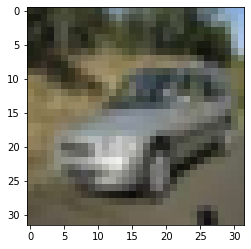

In [8]:
## take(n) : batch n개를 가져옵니다.
train_sample = train_dataset.take(1)

for sample in train_sample:
    print(sample['label'].shape)
    print(sample['image'].shape)
    print(sample['label'][0])
    plt.imshow(sample['image'][0])

## KID

* KID : Kernel Inception Distance
* MMD(Maximum Mean Discrepancy)를 feature space에서 진행하는 것을 의미
* 실제 이미지와 가짜 이미지, 가짜 이미지와 실제 이미지 세트간의 similarity를 보는 방법
* 실제 이미지 셋 p, 가짜 이미지셋 q라고 두고
* p에서 2장을 뽑고 두 이미지간의 차이를 구하는 것을 반복해서 이미지들간의 차이가 어떻게 되는지 기댓값을 구합니다.
* q에서도 똑같은 행동을 취합니다.
* 마지막으로 p에서 하나, q에서 하나를 뽑아서 평균적인 차이를 구합니다.

In [9]:
class KID(keras.metrics.Metric):
    def __init__(self, name, **kwargs):
        super().__init__(name=name, **kwargs)

        # KID 배치마다 계산되며 배치간의 값들로 평균을 냅니다.
        self.kid_tracker = keras.metrics.Mean(name="kid_tracker")

        # a pretrained InceptionV3 is used without its classification layer
        # transform the pixel values to the 0-255 range, then use the same
        # preprocessing as during pretraining
        self.encoder = keras.Sequential(
            [
                keras.Input(shape=(image_size, image_size, 3)),
                layers.Rescaling(255.0),
                layers.Resizing(height=kid_image_size, width=kid_image_size),
                layers.Lambda(keras.applications.inception_v3.preprocess_input),
                keras.applications.InceptionV3(
                    include_top=False,
                    input_shape=(kid_image_size, kid_image_size, 3),
                    weights="imagenet",
                ),
                layers.GlobalAveragePooling2D(),
            ],
            name="inception_encoder",
        )

    def polynomial_kernel(self, features_1, features_2):
        feature_dimensions = tf.cast(tf.shape(features_1)[1], dtype=tf.float32)
        return (features_1 @ tf.transpose(features_2) / feature_dimensions + 1.0) ** 3.0

    def update_state(self, real_images, generated_images, sample_weight=None):
        real_features = self.encoder(real_images, training=False)
        generated_features = self.encoder(generated_images, training=False)

        # compute polynomial kernels using the two sets of features
        kernel_real = self.polynomial_kernel(real_features, real_features)
        kernel_generated = self.polynomial_kernel(
            generated_features, generated_features
        )
        kernel_cross = self.polynomial_kernel(real_features, generated_features)

        # estimate the squared maximum mean discrepancy using the average kernel values
        batch_size = tf.shape(real_features)[0]
        batch_size_f = tf.cast(batch_size, dtype=tf.float32)
        mean_kernel_real = tf.reduce_sum(kernel_real * (1.0 - tf.eye(batch_size))) / (
            batch_size_f * (batch_size_f - 1.0)
        )
        mean_kernel_generated = tf.reduce_sum(
            kernel_generated * (1.0 - tf.eye(batch_size))
        ) / (batch_size_f * (batch_size_f - 1.0))
        mean_kernel_cross = tf.reduce_mean(kernel_cross)
        kid = mean_kernel_real + mean_kernel_generated - 2.0 * mean_kernel_cross

        # update the average KID estimate
        self.kid_tracker.update_state(kid)

    def result(self):
        return self.kid_tracker.result()

    def reset_state(self):
        self.kid_tracker.reset_state()


## 네트워크 구조

* U-Net 구조 : Input과 Output이 동일한 형태로
* Downsampling 한 뒤 Upsampling 하는 구조, layer들 간의 skip connectoins은 같은 resolutoin을 가진다.
* 네트워크는 noisy image와 noisy variances 2개의 값을 입력 받습니다.
* Noise variances는 노이즈 제거 과정이 다른 레벨의 노이즈에서 다른 명령(함수)가 필요하기 때문입니다.
* Noise variacnes는 sinusoidal embedding(positional embedding과 비슷한)을 통해 변환됩니다.
* 이 과정은 네트워크가 noise level에 매우 민감하게 만들어주며 이는 좋은 성능과 연결됩니다.
* Lambda layer를 통해 sinusoidal embedding을 구현하였습니다.

### Class Conditioning

In [ ]:
class ClassConditioning(Layer):
    def __init__(self, image, num_channels=3):
        super().__init__()
        self.block = Sequential([
            nn.Dense(image * image * num_channels),
            SiLU(),
            nn.Reshape((res, res, num_channels))
        ])

        self.block.compile()

    def call(self, x):
        return self.block(x)

### Sinusoidal Embedding

In [10]:
def sinusoidal_embedding(x):
    embedding_min_frequency = 1.0
    frequencies = tf.exp(
        tf.linspace(
            tf.math.log(embedding_min_frequency),
            tf.math.log(embedding_max_frequency),
            embedding_dims // 2,
        )
    )
    angular_speeds = 2.0 * math.pi * frequencies
    embeddings = tf.concat(
        [tf.sin(angular_speeds * x), tf.cos(angular_speeds * x)], axis=3
    )
    return embeddings

### Residual Block

In [11]:
def ResidualBlock(width):
    def apply(x):
        input_width = x.shape[3]
        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(width, kernel_size=1)(x)
        x = layers.BatchNormalization(center=False, scale=False)(x)
        x = layers.Conv2D(
            width, kernel_size=3, padding="same", activation=keras.activations.swish
        )(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same")(x)
        x = layers.Add()([x, residual])
        return x

    return apply

### Up Down Block

In [12]:
def DownBlock(width, block_depth):
    def apply(x):
        x, skips = x
        for _ in range(block_depth):
            x = ResidualBlock(width)(x)
            skips.append(x)
            ClassConditioning(x)
        x = layers.AveragePooling2D(pool_size=2)(x)
        return x

    return apply


def UpBlock(width, block_depth):
    def apply(x):
        x, skips = x
        x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)
        for _ in range(block_depth):
            x = layers.Concatenate()([x, skips.pop()])
            x = ResidualBlock(width)(x)
        return x

    return apply

## Get Network

### Before

In [13]:
# def get_network_before(image_size, widths, block_depth):
#     noisy_images = keras.Input(shape=(image_size, image_size, 3))
#     noise_variances = keras.Input(shape=(1, 1, 1))

#     e = layers.Lambda(sinusoidal_embedding)(noise_variances)
#     e = layers.UpSampling2D(size=image_size, interpolation="nearest")(e)

#     x = layers.Conv2D(widths[0], kernel_size=1)(noisy_images)
#     x = layers.Concatenate()([x, e])

#     skips = []
#     for width in widths[:-1]:
#         x = DownBlock(width, block_depth)([x, skips])

#     for _ in range(block_depth):
#         x = ResidualBlock(widths[-1])(x)

#     for width in reversed(widths[:-1]):
#         x = UpBlock(width, block_depth)([x, skips])

#     x = layers.Conv2D(3, kernel_size=1, kernel_initializer="zeros")(x)

#     return keras.Model([noisy_images, noise_variances], x, name="residual_unet")


### After

In [14]:
def get_network(image_size, widths, num_class, block_depth):
    noisy_images = keras.Input(shape=(image_size, image_size, 3))
    noise_variances = keras.Input(shape=(1, 1, 1))
    class_vector = keras.Input(shape = (num_class,))
    
    e = layers.Lambda(sinusoidal_embedding)(noise_variances)
#     print('e :', e)
    e = layers.UpSampling2D(size=image_size, interpolation="nearest")(e)
#     print('e :',e)
    
    i = layers.Dense(class_embedding_dims)(class_vector)
#     print('i :',i)
#     i = layers.Reshape((1,1,class_embedding_dims))(i)
    i = i[:,None,None,:]
#     print('i :',i)
    i = layers.UpSampling2D(size=image_size, interpolation="nearest")(i)
#     print('i :',i)
    
    x = layers.Conv2D(widths[0], kernel_size=1)(noisy_images)
    x = layers.Concatenate()([x, i, e])
#     print('x', x)

    # widths = [32, 64, 96, 128]
    skips = []
    for width in widths[:-1]:
        x = DownBlock(width, block_depth)([x, skips])

    for _ in range(block_depth):
        x = ResidualBlock(widths[-1])(x)

    for width in reversed(widths[:-1]):
        x = UpBlock(width, block_depth)([x, skips])

    x = layers.Conv2D(3, kernel_size=1, kernel_initializer="zeros")(x)
#     x = layers.Conv2D(1, kernel_size=1, kernel_initializer="zeros")(x)
    

    return keras.Model([noisy_images, noise_variances, class_vector], x, name="residual_unet")

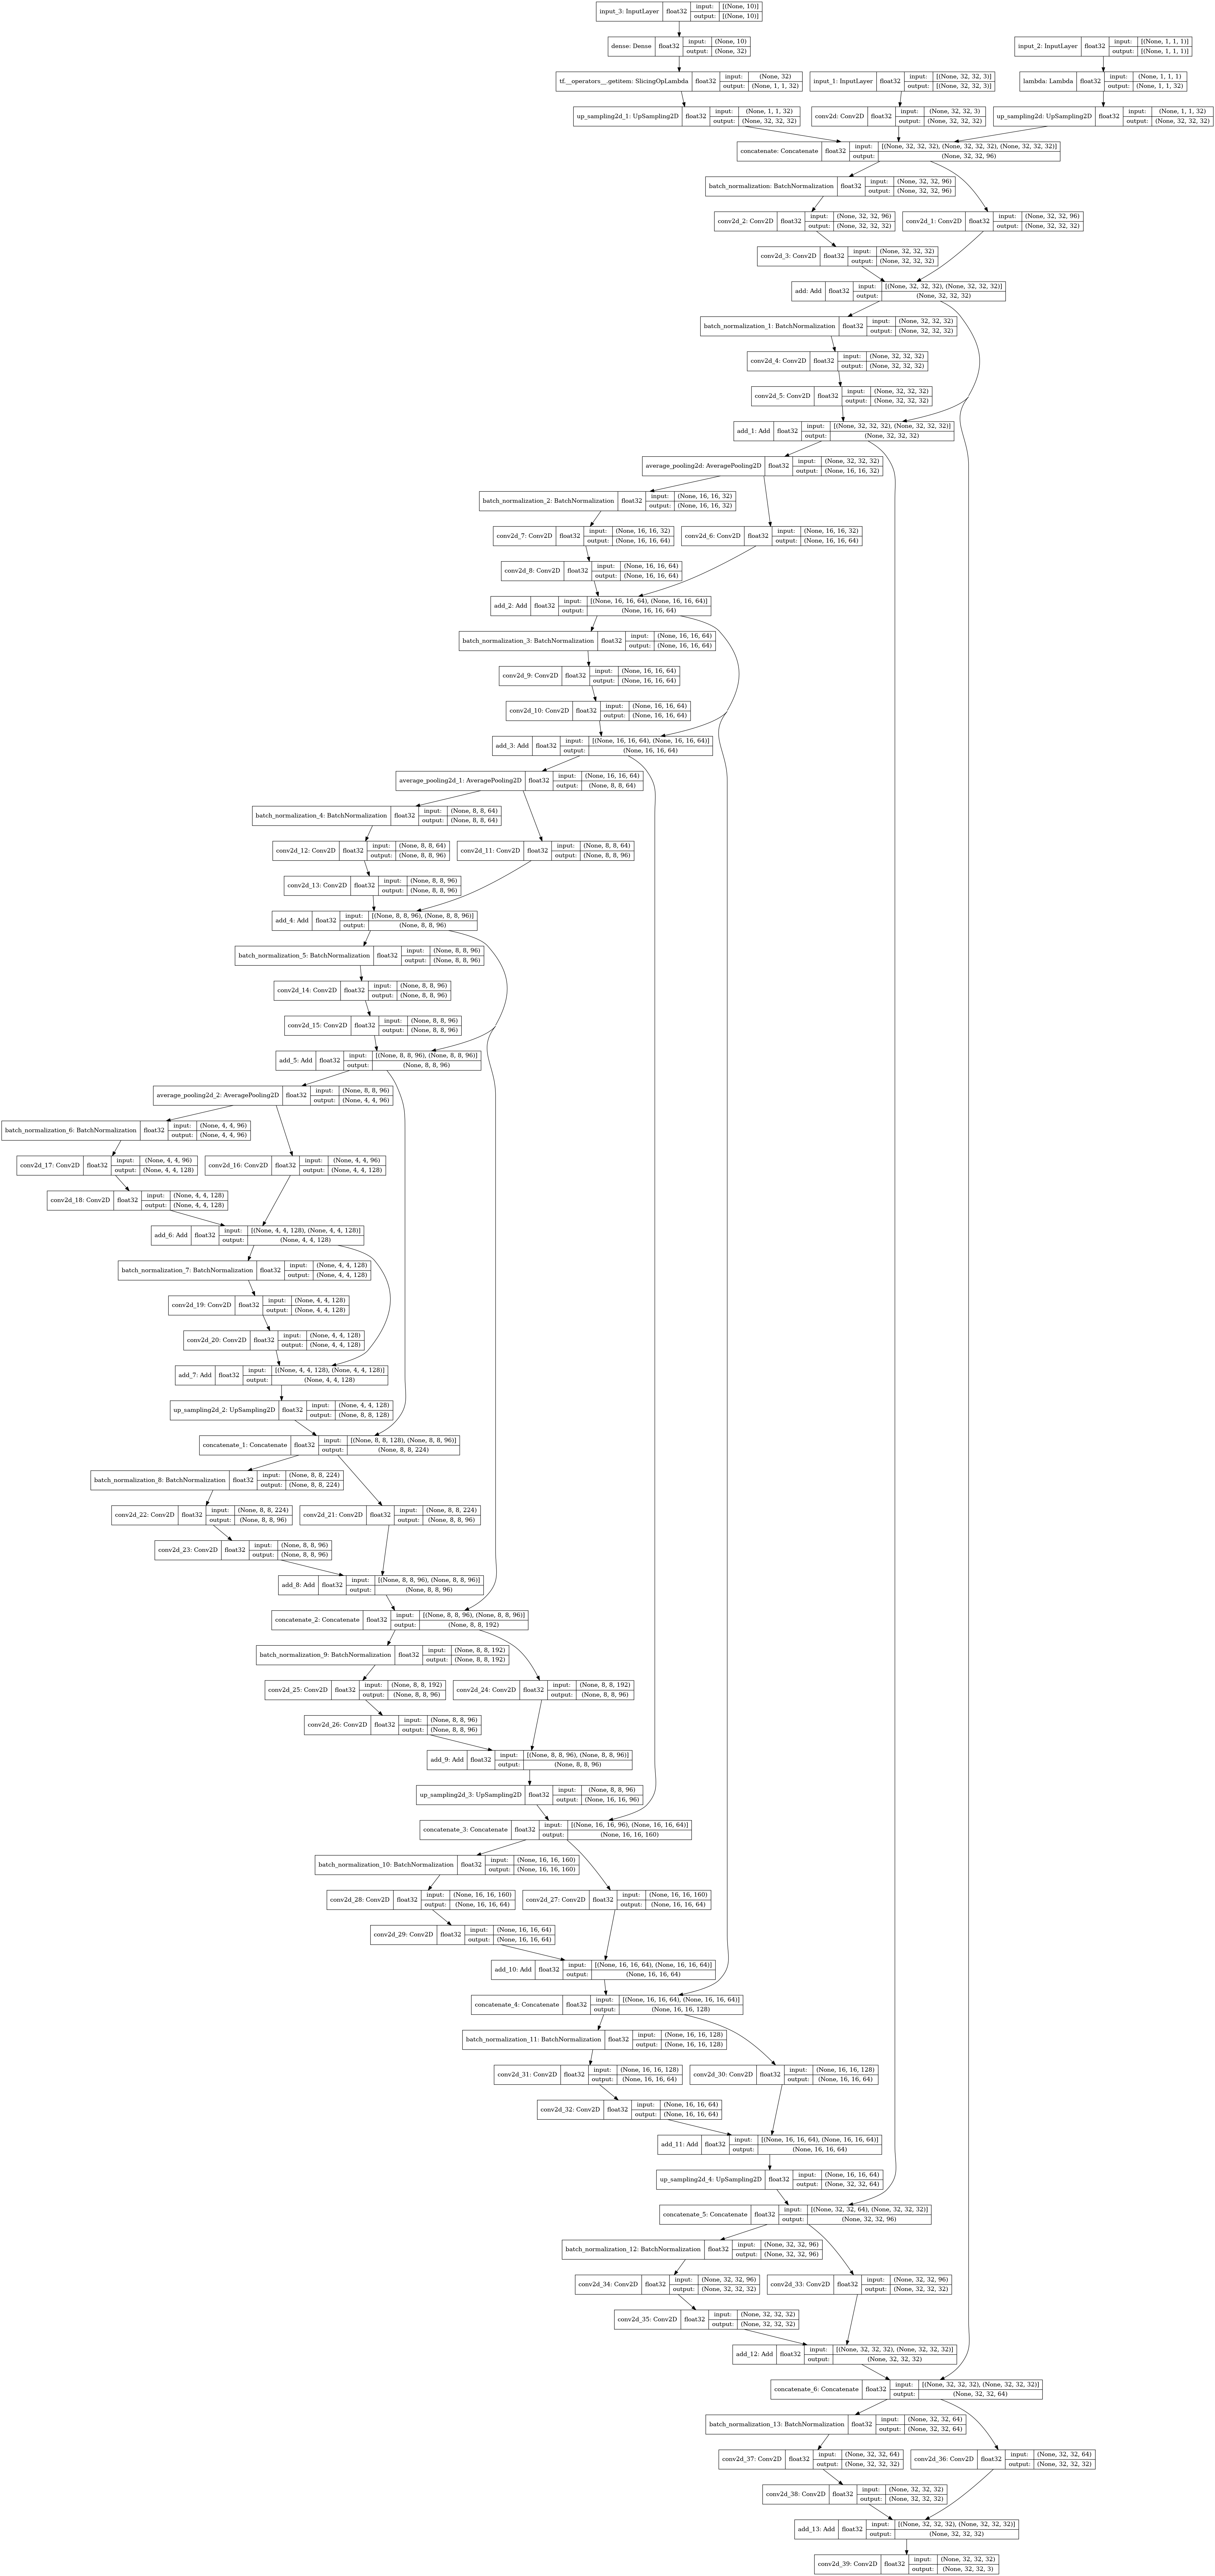

In [15]:
from tensorflow.keras.utils import plot_model

sample_network = get_network(image_size, widths, num_class, block_depth)

plot_model(sample_network, to_file = 'model.png', show_shapes = True, show_dtype = True, show_layer_names = True)


## Diffusion model

### Diffusion Schedule

* Diffusion process의 각 위치에서의 실제 diffusion time에 대응하는 noise level과 signal level를 말해주는 함수가 필요하다.
* 이것이 diffusion schedule 이다.
* Diffusion schedule은 2가지 값을 출력한다.
* noise_rate와 signal_rate(DDPM 논문에서 sqrt(1-alpha)와 sqrt(alpha)에 해당하는)
* 노이즈 이미지는 훈련 이미지에 정해진 비율에 따라 랜덤 노이즈를 부가하고 둘을 합치면서 생성한다.
* 랜덤 노이즈와 이미지가 모두 평균을 0으로 잡고 unit 분산을 가지기 때문에 노이즈 비율과 신호 비율은 노이즈 이미지에서 그들의 표준편차로 볼 수 있다.
* 그들 비율의 제곱은 결국 분산이 된다.
* 비율들은 제곱 합이 1이 되도록 설정되며, 이는 노이즈 이미지가 언제나 unit 분산을 가지는 것을 뜻합니다(변화되지않은 값들 처럼)
* 우린 cosine schedule의 simplifed, continuous 버전을 사용합니다.
* 이 스케쥴은 대칭적이며 Diffusion 시작과 끝을 향해선 느려지며, trigonometric properties of the unit circle을 통한 기하하적 해석을 가집니다.

### Training Process

* train 과정은 train_step과 denoise 이며
* 무작위 diffusion 시간을 균등하게 샘플하며
* 훈련 이미지와 무작위 가우시안 노이즈를 diffusion 시간에 따른 비율에 따라 섞습니다.
* 그리고 노이즈 이미지를 두 가지 요소로 나누기 위해 모델을 훈련합니다.
* 뉴런 네트워크는 변하지 않은 노이즈 요소를 예측하기 위해 학습되며 예측한 이미지 요소는 신호와 노이즈 비율에 따라 계산될 수 있습니다.
* 픽셀 단위의 MSE가 이론적으로 사용되나, 해당 dataset에서는 MAE가 더 좋게 나오니 이것을 사용하겠습니다.

### Sampling

* 샘플링에서는 (reverse diffusion()에서), 각 단계에서 노이즈 이미지의 이전 예측값을 우리의 네트워크를 사용해서 노이즈와 이미지로 나눕니다.
* 해당 단계에서의 신호와 노이즈 비율을 사용하여 다시 재결합합니다.
* Stochastic sampling 네트워크를 재훈련하지 않고도 사용할 수 있다(두 모델 다 같은 방식으로 훈련하기 때문)

In [16]:
class DiffusionModel(keras.Model):
    def __init__(self, image_size, widths, num_class, block_depth):
        super().__init__()

        self.normalizer = layers.Normalization()
        self.network = get_network(image_size, widths, num_class, block_depth)
        self.ema_network = keras.models.clone_model(self.network)

    def compile(self, **kwargs):
        super().compile(**kwargs)

        self.noise_loss_tracker = keras.metrics.Mean(name="n_loss")
        self.image_loss_tracker = keras.metrics.Mean(name="i_loss")
        self.kid = KID(name="kid")

    @property
    def metrics(self):
        return [self.noise_loss_tracker, self.image_loss_tracker, self.kid]

    def denormalize(self, images):
        # convert the pixel values back to 0-1 range
        images = self.normalizer.mean + images * self.normalizer.variance**0.5
        return tf.clip_by_value(images, 0.0, 1.0)

    def diffusion_schedule(self, diffusion_times):
        # diffusion times -> angles
        start_angle = tf.acos(max_signal_rate)
        end_angle = tf.acos(min_signal_rate)

        diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)

        # angles -> signal and noise rates
        signal_rates = tf.cos(diffusion_angles)
        noise_rates = tf.sin(diffusion_angles)
        # note that their squared sum is always: sin^2(x) + cos^2(x) = 1

        return noise_rates, signal_rates

    def denoise(self, noisy_images, noise_rates, signal_rates, class_vector, training):
        # print("denoise start")
        # the exponential moving average weights are used at evaluation
        if training:
            network = self.network
        else:
            network = self.ema_network

        # predict noise component and calculate the image component using it
        # pred_noises = network([noisy_images, noise_rates**2], training=training)
        pred_noises = network([noisy_images, noise_rates**2, class_vector], training=training)
        # print("denoise get noises")
    
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates
        # print("denoise get images") 
        
        return pred_noises, pred_images

    def reverse_diffusion(self, initial_noise, diffusion_steps, class_vector):
        # reverse diffusion = sampling
        num_images = initial_noise.shape[0]
        step_size = 1.0 / diffusion_steps

        # important line:
        # at the first sampling step, the "noisy image" is pure noise
        # but its signal rate is assumed to be nonzero (min_signal_rate)
        next_noisy_images = initial_noise
        for step in range(diffusion_steps):
            noisy_images = next_noisy_images

            # separate the current noisy image to its components
            diffusion_times = tf.ones((num_images, 1, 1, 1)) - step * step_size
            noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, class_vector, training=False
            )
            # network used in eval mode

            # remix the predicted components using the next signal and noise rates
            next_diffusion_times = diffusion_times - step_size
            next_noise_rates, next_signal_rates = self.diffusion_schedule(
                next_diffusion_times
            )
            next_noisy_images = (
                next_signal_rates * pred_images + next_noise_rates * pred_noises
            )
            # this new noisy image will be used in the next step

        return pred_images

    def generate(self, num_images, diffusion_steps, class_vector):
        # noise -> images -> denormalized images
        initial_noise = tf.random.normal(shape=(num_images, image_size, image_size, 3))
        generated_images = self.reverse_diffusion(initial_noise, diffusion_steps, class_vector)
        generated_images = self.denormalize(generated_images)
        return generated_images

    # def train_step(self, images):
    def train_step(self, data):
        # normalize images to have standard deviation of 1, like the noises
        # print("train_step start")
        images = data['image']
        label = data['label']
        # print(label)
        images = self.normalizer(images, training=True)
        noises = tf.random.normal(shape=(batch_size, image_size, image_size, 3))

        # sample uniform random diffusion times
        diffusion_times = tf.random.uniform(
            shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        # mix the images with noises accordingly
        noisy_images = signal_rates * images + noise_rates * noises

        # print("train_step here 1")
        # print("noise_rates :", noise_rates)
        # print("signal_rates :", signal_rates)
        # print("noisy_images :", noisy_images)
        
        with tf.GradientTape() as tape:
            # train the network to separate noisy images to their components
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, label, training=True
            )
            # print('start get loss')
            noise_loss = self.loss(noises, pred_noises)  # used for training
            # print('get noise loss')
            image_loss = self.loss(images, pred_images)  # only used as metric
            # print('get image loss')
            
            
        # print("train_step here 2")
        gradients = tape.gradient(noise_loss, self.network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights))

        self.noise_loss_tracker.update_state(noise_loss)
        self.image_loss_tracker.update_state(image_loss)

        # track the exponential moving averages of weights
        for weight, ema_weight in zip(self.network.weights, self.ema_network.weights):
            ema_weight.assign(ema * ema_weight + (1 - ema) * weight)
    
        # KID is not measured during the training phase for computational efficiency
        return {m.name: m.result() for m in self.metrics[:-1]}

    # def test_step(self, images):
    def test_step(self, data):
        images = data['image']
        label = data['label']
        # normalize images to have standard deviation of 1, like the noises
        images = self.normalizer(images, training=False)
        noises = tf.random.normal(shape=(batch_size, image_size, image_size, 3))

        # sample uniform random diffusion times
        diffusion_times = tf.random.uniform(
            shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        # mix the images with noises accordingly
        noisy_images = signal_rates * images + noise_rates * noises

        # use the network to separate noisy images to their components
        pred_noises, pred_images = self.denoise(
            noisy_images, noise_rates, signal_rates, label, training=False
        )

        noise_loss = self.loss(noises, pred_noises)
        image_loss = self.loss(images, pred_images)

        self.image_loss_tracker.update_state(image_loss)
        self.noise_loss_tracker.update_state(noise_loss)

        # measure KID between real and generated images
        # this is computationally demanding, kid_diffusion_steps has to be small
        images = self.denormalize(images)
        generated_images = self.generate(
            num_images=batch_size, diffusion_steps=kid_diffusion_steps, class_vector = label
        )
        self.kid.update_state(images, generated_images)

        return {m.name: m.result() for m in self.metrics}

    # plot random generated images for visual evaluation of generation quality
    def plot_images(self, epoch=None, logs=None, num_rows=2, num_cols=5):
    # def plot_images(self, epoch=None, logs=None, num_rows=1, num_cols=5):
        
        indices = [0,1,2,3,4,5,6,7,8,9]
        # indices = [0,1,2,3,4]
        sample_vector = tf.one_hot(indices, num_class)
        # sample_vector shape (10,10)
        generated_images = self.generate(
            num_images=num_rows * num_cols,
            diffusion_steps=plot_diffusion_steps,
            class_vector =  sample_vector 
        )
        # generated_images shape : (10,32,32,3)

        plt.figure(figsize=(num_cols * 2.0, num_rows * 2.0))
        for row in range(num_rows):
            for col in range(num_cols):
                index = row * num_cols + col
                plt.subplot(num_rows, num_cols, index + 1)
                plt.imshow(generated_images[index])
                plt.axis("off")
        plt.tight_layout()
        plt.show()
        plt.close()
        
    def plot_one_images(self, input_class = 0, epoch=None, logs=None):
        
        index = [input_class]
        sample_vector = tf.one_hot(index, num_class)
        # sample_vector shape : (1,10)
            
        generated_images = self.generate(
            num_images=1,
            diffusion_steps = one_plot_diffusion_steps,
            class_vector =  sample_vector 
        )
        # generated_images shape : (1,32,32,3)
        
        plt.figure(figsize=(6,6))
        plt.imshow(generated_images[0])
        plt.axis("off")
        plt.tight_layout()
        plt.show()
        plt.close()
    

## 학습

In [17]:
!pip install tensorflow_addons

In [18]:
import tensorflow_addons as tfa

# create and compile the model
model = DiffusionModel(image_size, widths, num_class, block_depth)
# below tensorflow 2.9:
# pip install tensorflow_addons
# import tensorflow_addons as tfa
# optimizer=tfa.optimizers.AdamW
model.compile(
    optimizer=tfa.optimizers.AdamW(
#     optimizer=keras.optimizers.experimental.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    loss=keras.losses.MeanSquaredError(),
)
# pixelwise mean absolute error is used as loss

In [19]:
# save the best model based on the validation KID metric
checkpoint_path = "checkpoint/diffusion_model"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor="val_kid",
    mode="min",
    save_best_only=True,
)

In [20]:
# calculate mean and variance of training dataset for normalization
# 이미지와 label로 데이터셋의 형태가 변하였기 때문에 image만 가져와서 adapt 시켜줍니다.
train_image = train_dataset.map(lambda x : x['image'])
model.normalizer.adapt(train_image)

Epoch 1/50
625/625 [==============================] - 65s 92ms/step - n_loss: 0.1026 - i_loss: 1.5562 - val_n_loss: 0.9689 - val_i_loss: 38.8791 - val_kid: 0.8892


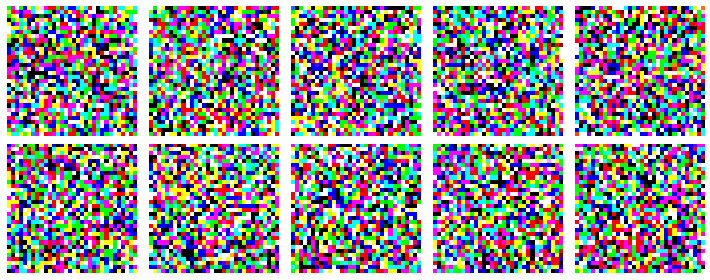

Epoch 2/50
625/625 [==============================] - 51s 82ms/step - n_loss: 0.0649 - i_loss: 0.3180 - val_n_loss: 0.7374 - val_i_loss: 24.9951 - val_kid: 0.8593


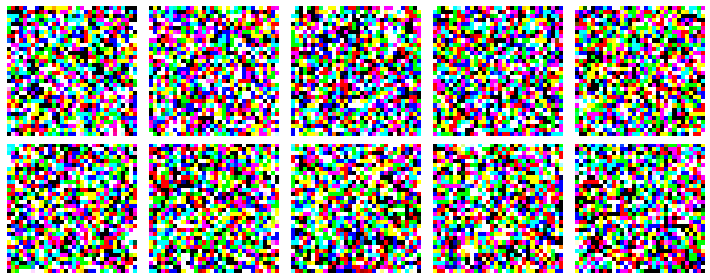

Epoch 3/50
625/625 [==============================] - 52s 82ms/step - n_loss: 0.0622 - i_loss: 0.2799 - val_n_loss: 0.4275 - val_i_loss: 12.5734 - val_kid: 0.8504


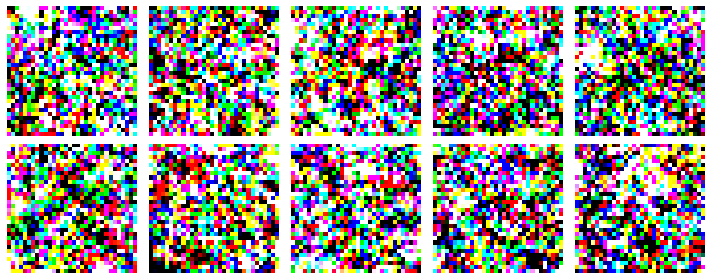

Epoch 4/50
625/625 [==============================] - 52s 82ms/step - n_loss: 0.0602 - i_loss: 0.2653 - val_n_loss: 0.2249 - val_i_loss: 5.1552 - val_kid: 0.8907


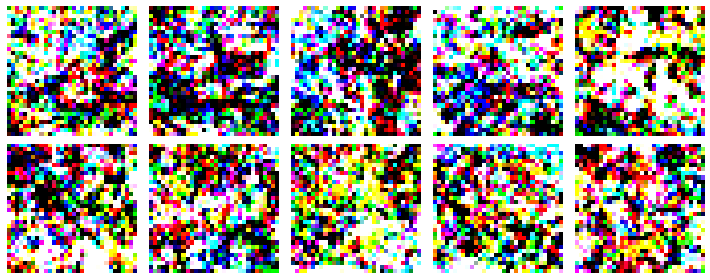

Epoch 5/50
625/625 [==============================] - 51s 82ms/step - n_loss: 0.0594 - i_loss: 0.2437 - val_n_loss: 0.1248 - val_i_loss: 2.0588 - val_kid: 0.8984


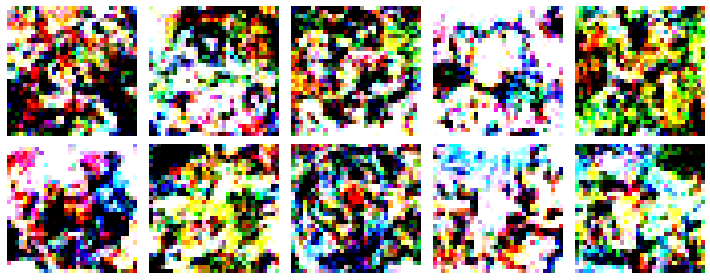

Epoch 6/50
625/625 [==============================] - 51s 82ms/step - n_loss: 0.0589 - i_loss: 0.2397 - val_n_loss: 0.0813 - val_i_loss: 0.9221 - val_kid: 0.6803


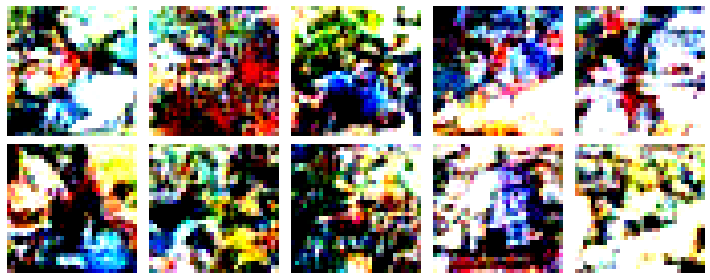

Epoch 7/50
625/625 [==============================] - 51s 82ms/step - n_loss: 0.0584 - i_loss: 0.2344 - val_n_loss: 0.0642 - val_i_loss: 0.4471 - val_kid: 0.4937


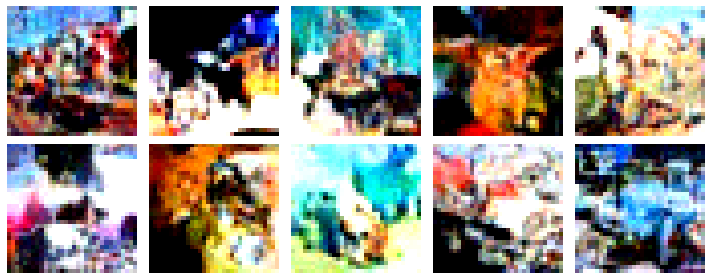

Epoch 8/50
625/625 [==============================] - 52s 82ms/step - n_loss: 0.0579 - i_loss: 0.2403 - val_n_loss: 0.0584 - val_i_loss: 0.2537 - val_kid: 0.3649


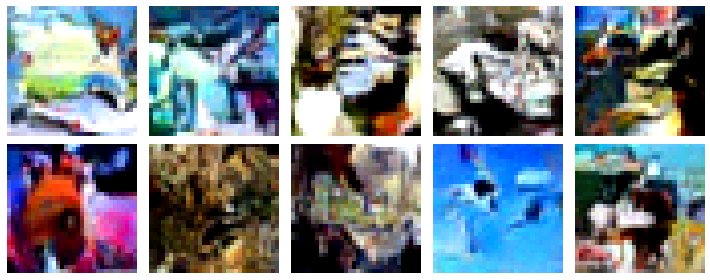

Epoch 9/50
625/625 [==============================] - 52s 83ms/step - n_loss: 0.0577 - i_loss: 0.2243 - val_n_loss: 0.0562 - val_i_loss: 0.2018 - val_kid: 0.2426


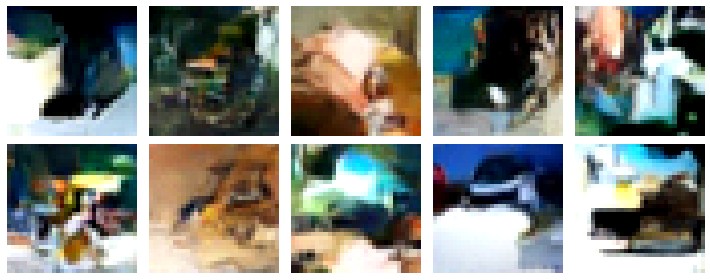

Epoch 10/50
625/625 [==============================] - 52s 82ms/step - n_loss: 0.0573 - i_loss: 0.2262 - val_n_loss: 0.0559 - val_i_loss: 0.1821 - val_kid: 0.1835


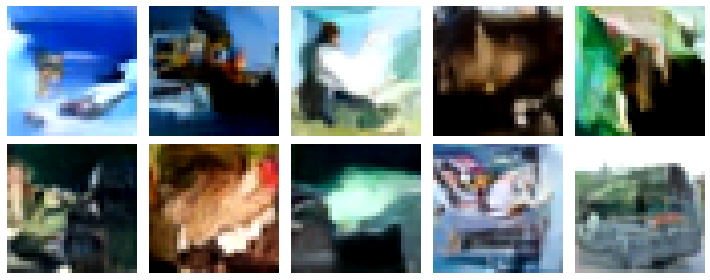

Epoch 11/50
625/625 [==============================] - 52s 82ms/step - n_loss: 0.0576 - i_loss: 0.2221 - val_n_loss: 0.0549 - val_i_loss: 0.1780 - val_kid: 0.1547


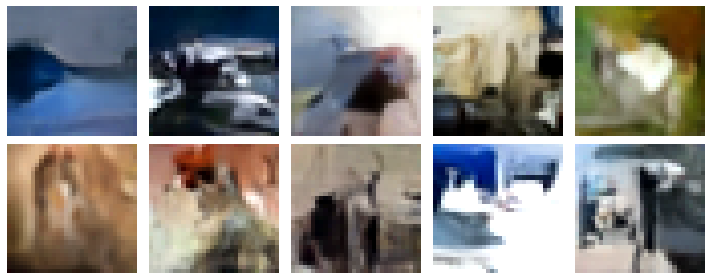

Epoch 12/50
625/625 [==============================] - 51s 82ms/step - n_loss: 0.0573 - i_loss: 0.2186 - val_n_loss: 0.0549 - val_i_loss: 0.1693 - val_kid: 0.1467


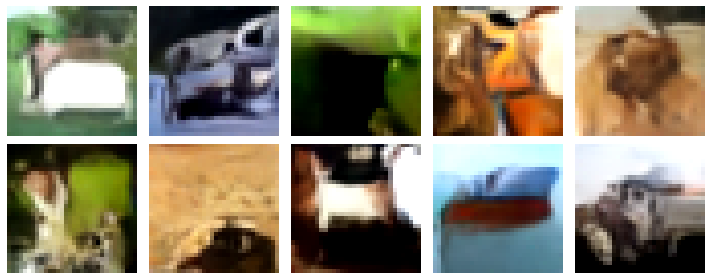

Epoch 13/50
625/625 [==============================] - 52s 82ms/step - n_loss: 0.0566 - i_loss: 0.2242 - val_n_loss: 0.0541 - val_i_loss: 0.1700 - val_kid: 0.1491


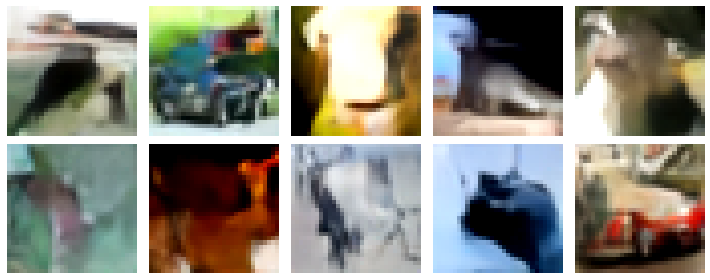

Epoch 14/50
625/625 [==============================] - 51s 82ms/step - n_loss: 0.0565 - i_loss: 0.2193 - val_n_loss: 0.0543 - val_i_loss: 0.1711 - val_kid: 0.1479


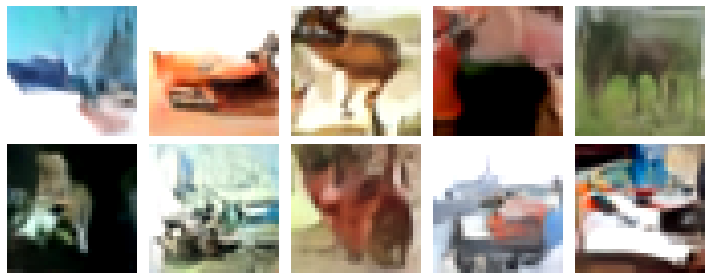

Epoch 15/50
625/625 [==============================] - 51s 82ms/step - n_loss: 0.0564 - i_loss: 0.2139 - val_n_loss: 0.0538 - val_i_loss: 0.1698 - val_kid: 0.1425


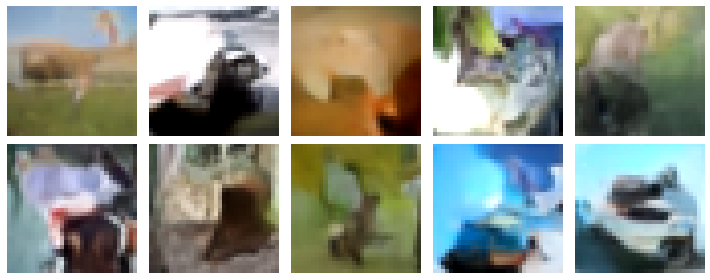

Epoch 16/50
625/625 [==============================] - 51s 82ms/step - n_loss: 0.0567 - i_loss: 0.2152 - val_n_loss: 0.0540 - val_i_loss: 0.1623 - val_kid: 0.1447


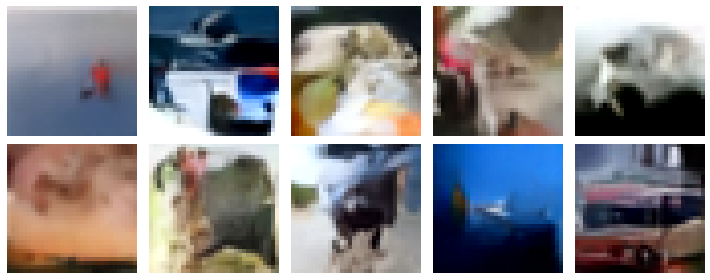

Epoch 17/50
625/625 [==============================] - 51s 82ms/step - n_loss: 0.0563 - i_loss: 0.2111 - val_n_loss: 0.0546 - val_i_loss: 0.1639 - val_kid: 0.1447


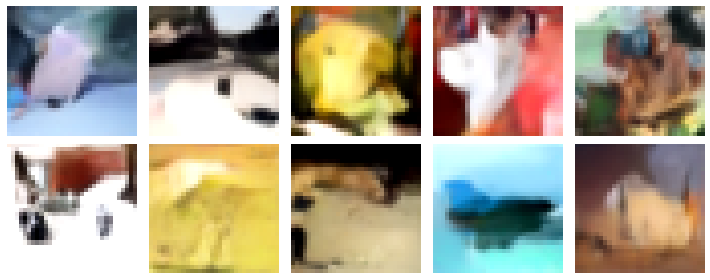

Epoch 18/50
625/625 [==============================] - 51s 82ms/step - n_loss: 0.0559 - i_loss: 0.2164 - val_n_loss: 0.0542 - val_i_loss: 0.1648 - val_kid: 0.1496


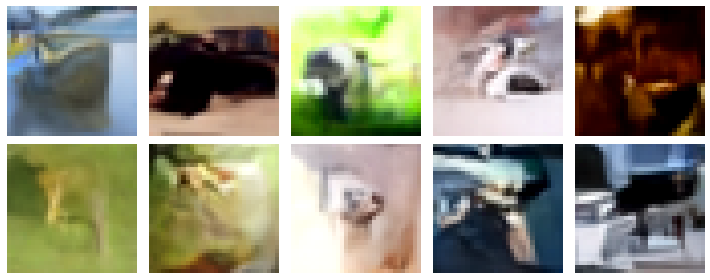

Epoch 19/50
625/625 [==============================] - 51s 82ms/step - n_loss: 0.0560 - i_loss: 0.2096 - val_n_loss: 0.0533 - val_i_loss: 0.1632 - val_kid: 0.1519


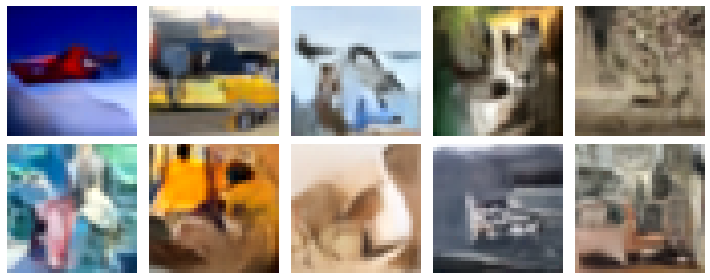

Epoch 20/50
625/625 [==============================] - 51s 82ms/step - n_loss: 0.0555 - i_loss: 0.2144 - val_n_loss: 0.0536 - val_i_loss: 0.1624 - val_kid: 0.1513


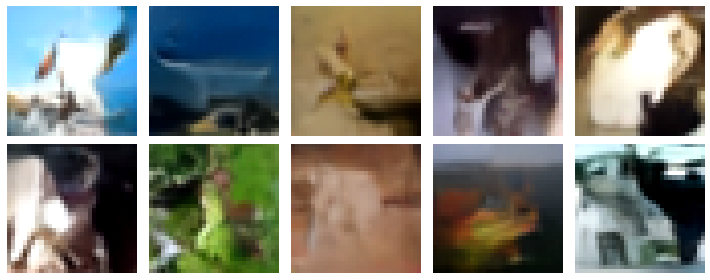

Epoch 21/50
625/625 [==============================] - 51s 82ms/step - n_loss: 0.0562 - i_loss: 0.2105 - val_n_loss: 0.0531 - val_i_loss: 0.1638 - val_kid: 0.1470


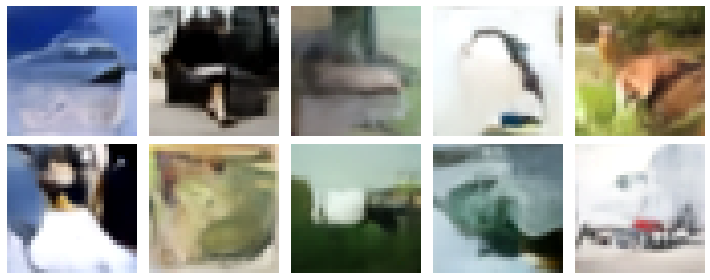

Epoch 22/50
625/625 [==============================] - 51s 82ms/step - n_loss: 0.0556 - i_loss: 0.2075 - val_n_loss: 0.0538 - val_i_loss: 0.1635 - val_kid: 0.1522


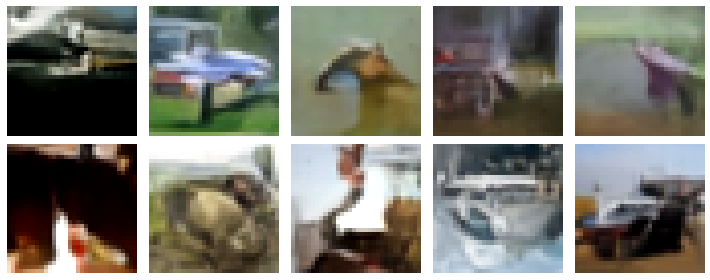

Epoch 23/50
625/625 [==============================] - 51s 82ms/step - n_loss: 0.0563 - i_loss: 0.2098 - val_n_loss: 0.0537 - val_i_loss: 0.1584 - val_kid: 0.1433


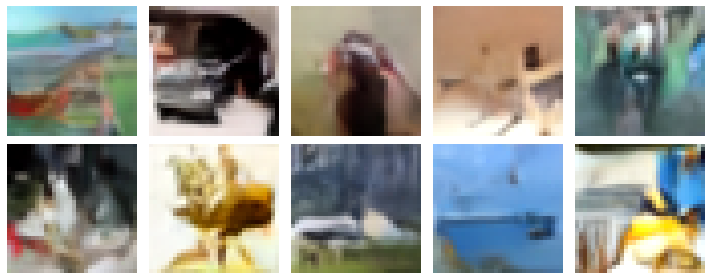

Epoch 24/50
625/625 [==============================] - 51s 82ms/step - n_loss: 0.0558 - i_loss: 0.2079 - val_n_loss: 0.0536 - val_i_loss: 0.1595 - val_kid: 0.1484


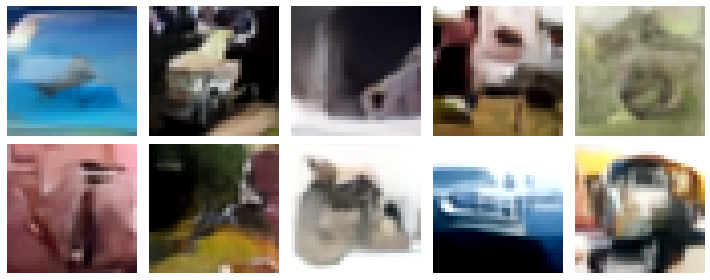

Epoch 25/50
625/625 [==============================] - 51s 82ms/step - n_loss: 0.0551 - i_loss: 0.2095 - val_n_loss: 0.0529 - val_i_loss: 0.1614 - val_kid: 0.1506


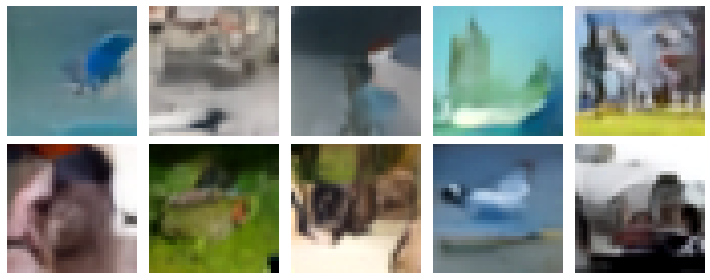

Epoch 26/50
625/625 [==============================] - 51s 82ms/step - n_loss: 0.0558 - i_loss: 0.2127 - val_n_loss: 0.0529 - val_i_loss: 0.1670 - val_kid: 0.1535


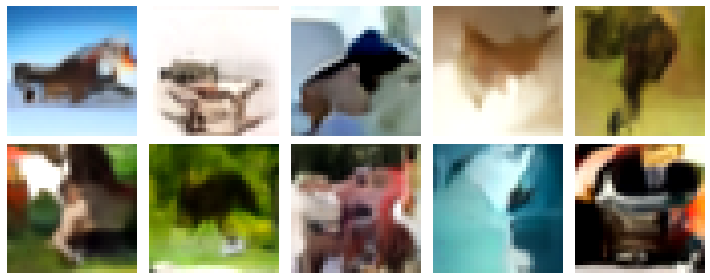

Epoch 27/50
625/625 [==============================] - 51s 82ms/step - n_loss: 0.0553 - i_loss: 0.2126 - val_n_loss: 0.0535 - val_i_loss: 0.1621 - val_kid: 0.1604


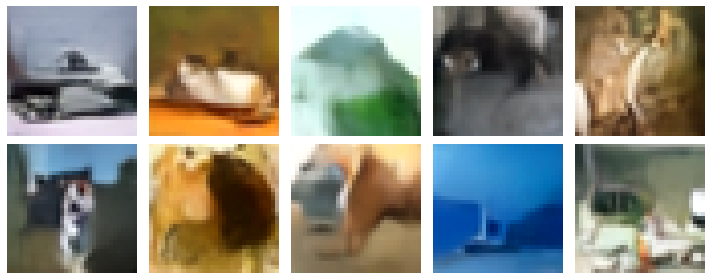

Epoch 28/50
625/625 [==============================] - 51s 82ms/step - n_loss: 0.0554 - i_loss: 0.2056 - val_n_loss: 0.0535 - val_i_loss: 0.1607 - val_kid: 0.1517


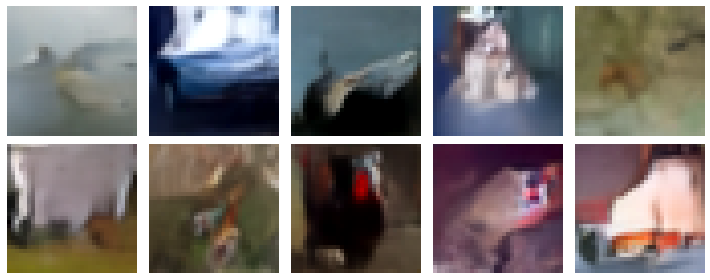

Epoch 29/50
625/625 [==============================] - 51s 82ms/step - n_loss: 0.0554 - i_loss: 0.2075 - val_n_loss: 0.0536 - val_i_loss: 0.1586 - val_kid: 0.1543


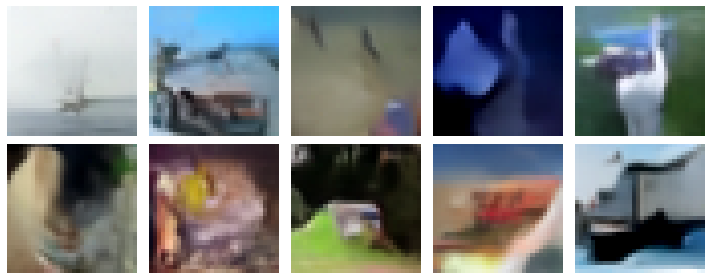

Epoch 30/50
625/625 [==============================] - 51s 82ms/step - n_loss: 0.0555 - i_loss: 0.2103 - val_n_loss: 0.0539 - val_i_loss: 0.1573 - val_kid: 0.1545


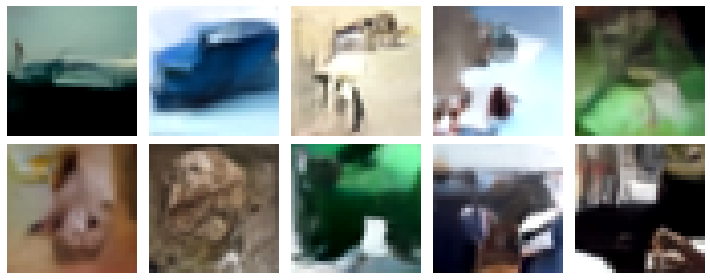

Epoch 31/50
625/625 [==============================] - 51s 82ms/step - n_loss: 0.0551 - i_loss: 0.2079 - val_n_loss: 0.0530 - val_i_loss: 0.1630 - val_kid: 0.1436


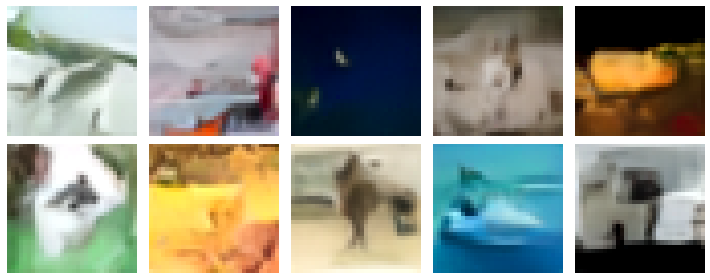

Epoch 32/50
625/625 [==============================] - 51s 82ms/step - n_loss: 0.0552 - i_loss: 0.2107 - val_n_loss: 0.0527 - val_i_loss: 0.1587 - val_kid: 0.1456


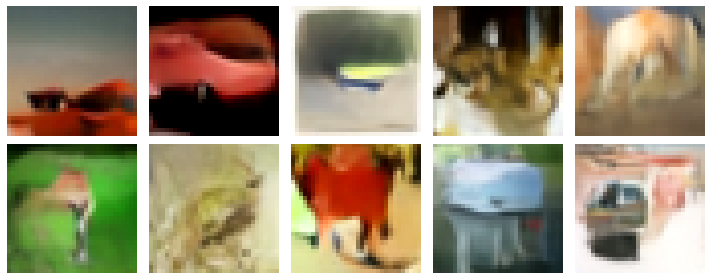

Epoch 33/50
625/625 [==============================] - 51s 82ms/step - n_loss: 0.0549 - i_loss: 0.2078 - val_n_loss: 0.0536 - val_i_loss: 0.1566 - val_kid: 0.1485


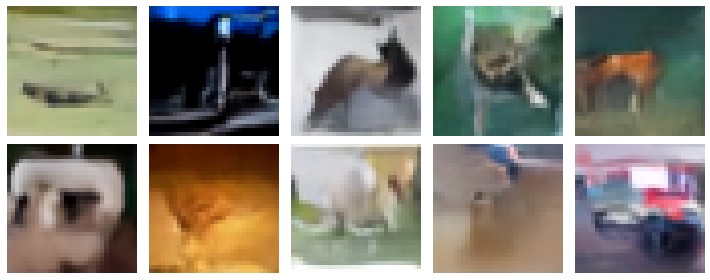

Epoch 34/50
625/625 [==============================] - 51s 82ms/step - n_loss: 0.0555 - i_loss: 0.2048 - val_n_loss: 0.0528 - val_i_loss: 0.1637 - val_kid: 0.1397


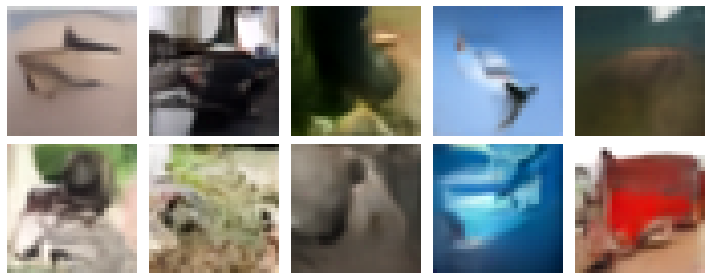

Epoch 35/50
625/625 [==============================] - 51s 82ms/step - n_loss: 0.0558 - i_loss: 0.1993 - val_n_loss: 0.0538 - val_i_loss: 0.1574 - val_kid: 0.1375


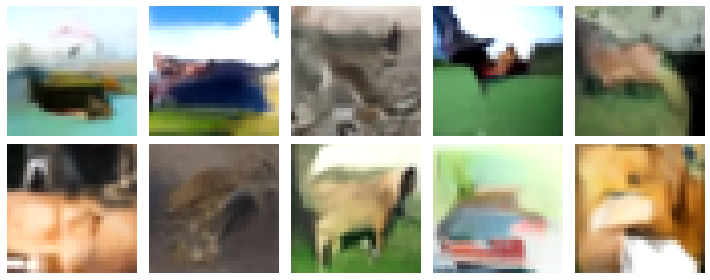

Epoch 36/50
625/625 [==============================] - 51s 82ms/step - n_loss: 0.0551 - i_loss: 0.2072 - val_n_loss: 0.0531 - val_i_loss: 0.1613 - val_kid: 0.1449


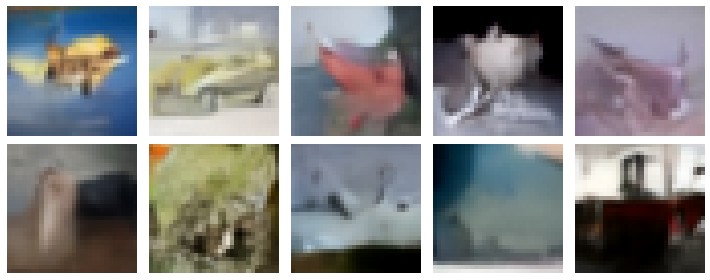

Epoch 37/50
625/625 [==============================] - 51s 82ms/step - n_loss: 0.0551 - i_loss: 0.2063 - val_n_loss: 0.0535 - val_i_loss: 0.1598 - val_kid: 0.1393


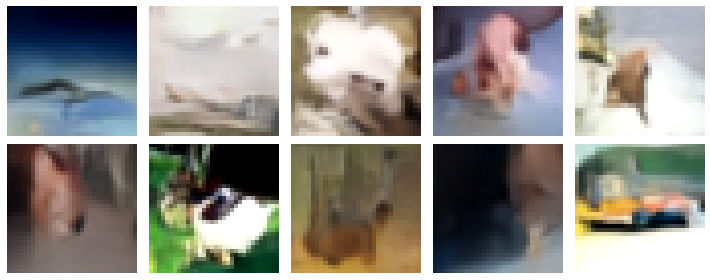

Epoch 38/50
625/625 [==============================] - 51s 82ms/step - n_loss: 0.0550 - i_loss: 0.2059 - val_n_loss: 0.0530 - val_i_loss: 0.1577 - val_kid: 0.1379


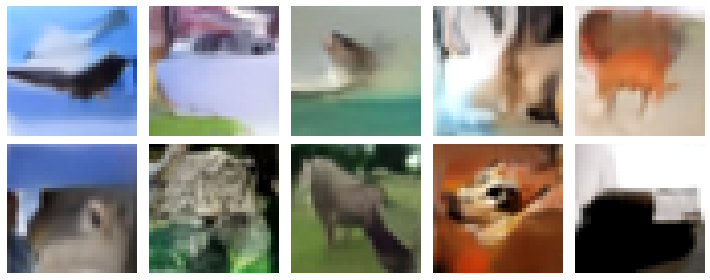

Epoch 39/50
625/625 [==============================] - 51s 82ms/step - n_loss: 0.0553 - i_loss: 0.2063 - val_n_loss: 0.0530 - val_i_loss: 0.1550 - val_kid: 0.1436


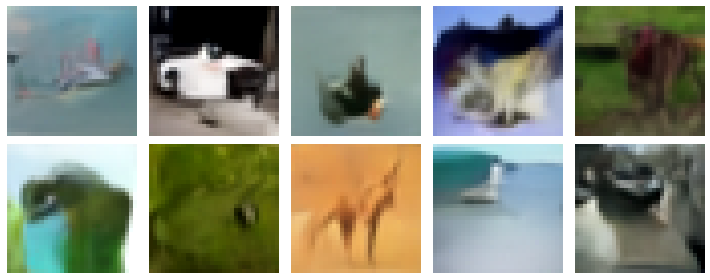

Epoch 40/50
625/625 [==============================] - 51s 82ms/step - n_loss: 0.0553 - i_loss: 0.2054 - val_n_loss: 0.0526 - val_i_loss: 0.1581 - val_kid: 0.1459


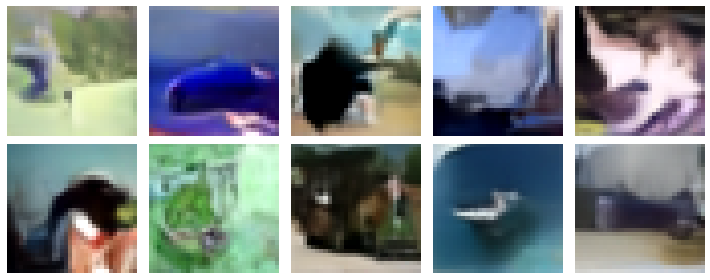

Epoch 41/50
625/625 [==============================] - 51s 82ms/step - n_loss: 0.0550 - i_loss: 0.2056 - val_n_loss: 0.0533 - val_i_loss: 0.1546 - val_kid: 0.1467


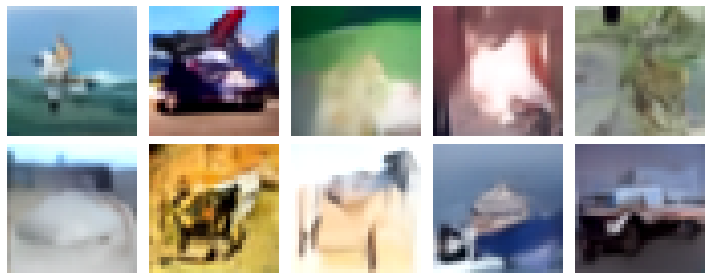

Epoch 42/50
625/625 [==============================] - 51s 82ms/step - n_loss: 0.0546 - i_loss: 0.2052 - val_n_loss: 0.0530 - val_i_loss: 0.1575 - val_kid: 0.1515


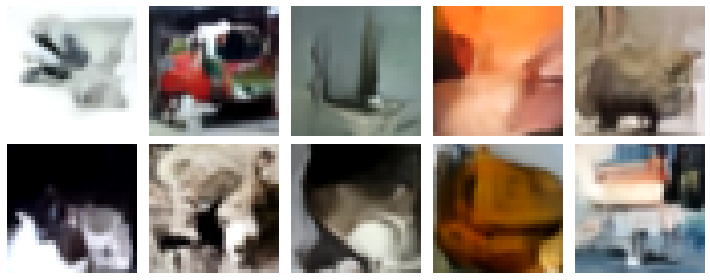

Epoch 43/50
625/625 [==============================] - 51s 82ms/step - n_loss: 0.0552 - i_loss: 0.2072 - val_n_loss: 0.0528 - val_i_loss: 0.1562 - val_kid: 0.1502


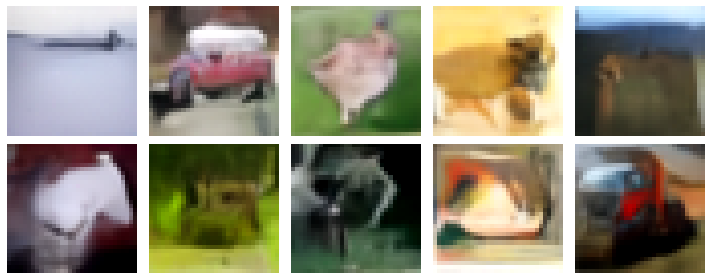

Epoch 44/50
625/625 [==============================] - 51s 82ms/step - n_loss: 0.0554 - i_loss: 0.1994 - val_n_loss: 0.0528 - val_i_loss: 0.1634 - val_kid: 0.1441


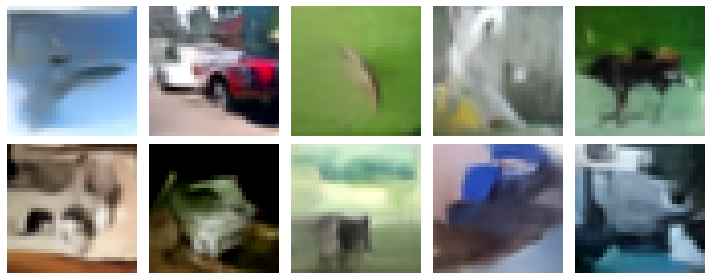

Epoch 45/50
625/625 [==============================] - 51s 82ms/step - n_loss: 0.0549 - i_loss: 0.2026 - val_n_loss: 0.0531 - val_i_loss: 0.1567 - val_kid: 0.1413


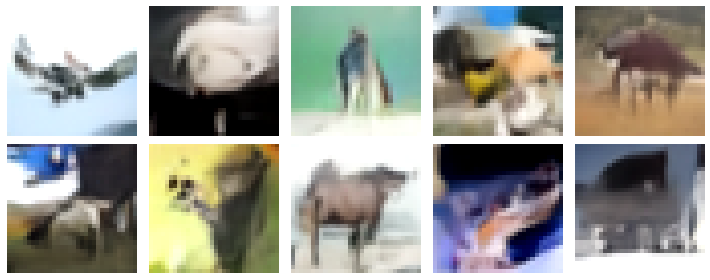

Epoch 46/50
625/625 [==============================] - 51s 82ms/step - n_loss: 0.0550 - i_loss: 0.2052 - val_n_loss: 0.0533 - val_i_loss: 0.1593 - val_kid: 0.1351


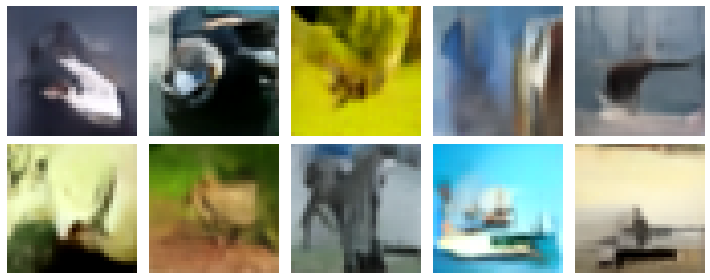

Epoch 47/50
625/625 [==============================] - 51s 82ms/step - n_loss: 0.0549 - i_loss: 0.2079 - val_n_loss: 0.0530 - val_i_loss: 0.1570 - val_kid: 0.1338


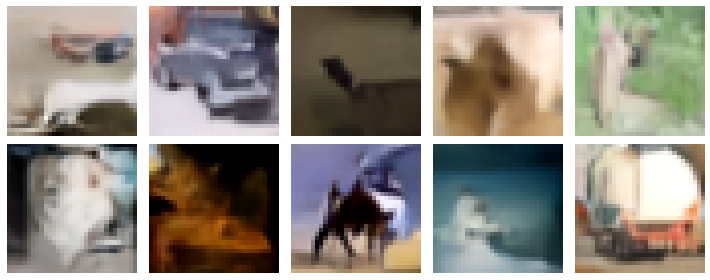

Epoch 48/50
625/625 [==============================] - 51s 82ms/step - n_loss: 0.0549 - i_loss: 0.2063 - val_n_loss: 0.0527 - val_i_loss: 0.1559 - val_kid: 0.1434


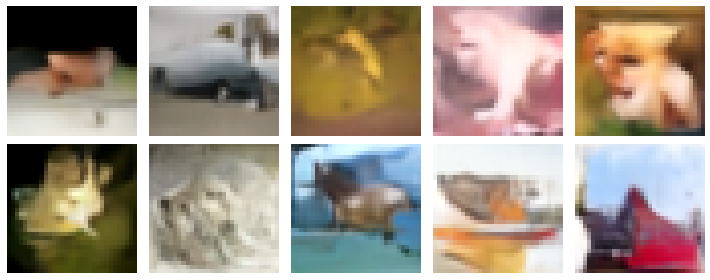

Epoch 49/50
625/625 [==============================] - 51s 82ms/step - n_loss: 0.0546 - i_loss: 0.2048 - val_n_loss: 0.0533 - val_i_loss: 0.1592 - val_kid: 0.1372


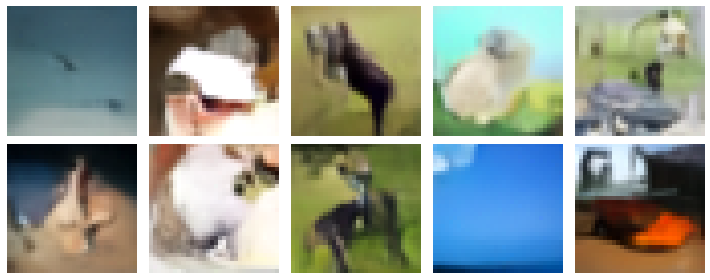

Epoch 50/50
625/625 [==============================] - 51s 82ms/step - n_loss: 0.0547 - i_loss: 0.2055 - val_n_loss: 0.0526 - val_i_loss: 0.1568 - val_kid: 0.1441


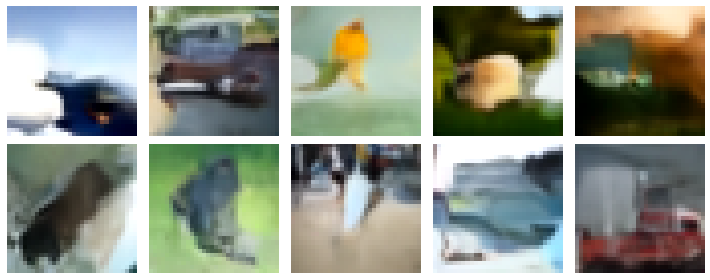

In [21]:
# run training and plot generated images periodically
model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=val_dataset,
    callbacks=[
        keras.callbacks.LambdaCallback(on_epoch_end = model.plot_images),
        checkpoint_callback,
    ],
)

## 0.airplane / 1.automobile / 2.bird / 3.cat / 4.deer / 5.dog / 6.frog / 7.horse / 8.ship / 9.truck

## 인퍼런스

### 전체 Class 출력

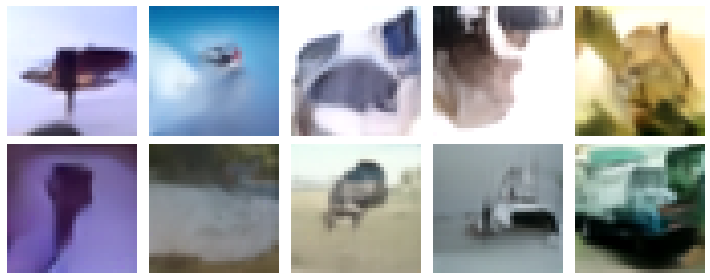

In [22]:
# load the best model and generate images
model.load_weights(checkpoint_path)
model.plot_images()

### 입력 클래스 출력

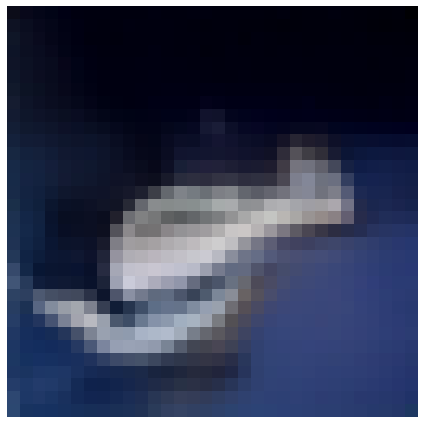

In [23]:
# 출력하고 싶은 class 번호 입력
input_value = 8
model.plot_one_images(input_class = input_value)